In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
from utils.station_network import StationNetworkSimul
from itertools import chain
import networkx as nx
from pyvis.network import Network
import random


In [4]:
df_stations = pd.read_csv('plan du métro.csv')
df_stations = df_stations[~df_stations['vers Ligne'].isin(['\xa01', '\xa07', '\xa02', '\xa08', '\xa06'])]

df_pos = pd.read_csv("position gps des stations de métro.csv")

#Removing Malsesherbes RER Station
df_pos = df_pos.drop([151])

df_flow = pd.read_csv('passagers.csv')
df_flow['nombre'] = df_flow['nombre'].astype(float)

In [17]:
test_network = StationNetworkSimul(df_stations=df_stations, df_pos=df_pos)

In [18]:
test_network.network_graph.nodes[0]

{'title': 'Abbesses',
 'group': '12',
 'lon': 2.3379497756920697,
 'lat': 48.884594208027806}

In [85]:
test_sparse = pd.DataFrame(
    np.zeros((df_flow.shape[0], len(test_network.network_graph.edges))),
    columns=[edge for edge in test_network.network_graph.edges],
    dtype=int)


In [94]:
for i, e in nx.utils.pairwise([1,2,3]):
    print((i,e))

(1, 2)
(2, 3)


In [86]:
test_sparse.iloc[0][(60,61)] = 1
test_sparse.iloc[0]

(60, 61)     1
(60, 62)     0
(60, 7)      0
(60, 137)    0
(61, 60)     0
            ..
(91, 27)     0
(91, 29)     0
(29, 91)     0
(29, 246)    0
(246, 29)    0
Name: 0, Length: 1054, dtype: int32

In [19]:
test_network.set_edges_weights()
test_network.set_nodes_traffic(df_flow=df_flow)
test_network.network_graph.nodes[0]

{'title': 'Abbesses',
 'group': '12',
 'lon': 2.3379497756920697,
 'lat': 48.884594208027806,
 'traffic': 9622.0}

In [99]:
test_network.shortest_path_cache[1]

[(164, 109), (109, 280)]

In [20]:
new_net, removed_edges = test_network.get_degraded_network()
removed_edges

[(21, 22),
 (75, 311),
 (144, 143),
 (184, 183),
 (77, 282),
 (126, 125),
 (85, 189),
 (38, 37),
 (311, 190),
 (321, 322)]

In [30]:
test_removed_edge = random.choice(removed_edges)
print(test_removed_edge)

test_affected_paths = test_network.shortest_path_cache_reverse[test_removed_edge]
print(len(test_affected_paths))

test_affected_path_idx = random.choice(test_affected_paths)
print(test_affected_path_idx)

start_path = df_flow.iloc[test_affected_path_idx]['de']
end_path = df_flow.iloc[test_affected_path_idx]['vers']

current_best_path = test_network.get_best_path(test_network.network_graph, start_path, end_path)
degraded_best_path = test_network.get_best_path(new_net, start_path, end_path)



(311, 190)
5169
46992


In [27]:
for neighbor in test_network.network_graph.neighbors(267):
    print(test_network.network_graph.nodes[neighbor]['title'], test_network.network_graph.nodes[neighbor]['group'])

Place d'Italie 5
Place d'Italie 7
Corvisart 6
Charles de Gaulle - Étoile 6
Nationale 6


In [31]:
print("->\n".join([f'{n} - {test_network.reverse_network_stations[n]["title"]} ({test_network.reverse_network_stations[n]["group"]})' for n in current_best_path]))

373 - Sully - Morland (7)->
278 - Pont Marie (7)->
77 - Châtelet (7)->
75 - Châtelet (14)->
311 - Pyramides (14)->
190 - Madeleine (14)->
191 - Madeleine (8)->
86 - Concorde (8)->
149 - Invalides (8)->
170 - La Tour-Maubourg (8)->
399 - École Militaire (8)->
168 - La Motte-Picquet - Grenelle (8)->
83 - Commerce (8)->
119 - Félix Faure (8)->
40 - Boucicaut (8)->
186 - Lourmel (8)->
16 - Balard (8)


In [32]:
print("->\n".join([f'{n} - {test_network.reverse_network_stations[n]["title"]} ({test_network.reverse_network_stations[n]["group"]})' for n in degraded_best_path]))

373 - Sully - Morland (7)->
160 - Jussieu (7)->
265 - Place Monge (7)->
54 - Censier - Daubenton (7)->
178 - Les Gobelins (7)->
268 - Place d'Italie (7)->
380 - Tolbiac (7)->
205 - Maison Blanche (7)->
173 - Le Kremlin-Bicêtre (7)->
392 - Villejuif - Léo Lagrange (7)->
393 - Villejuif - Paul Vaillant-Couturier (7)->
391 - Villejuif - Louis Aragon (7)->
287 - Porte d'Italie (7)->
293 - Porte de Choisy (7)->
288 - Porte d'Ivry (7)->
262 - Pierre et Marie Curie (7)->
195 - Mairie d'Ivry (7)->
196 - Mairie d'Ivry (7bis)->
184 - Louis Blanc (7bis)->
155 - Jaurès (7bis)->
36 - Bolivar (7bis)->
46 - Buttes Chaumont (7bis)->
39 - Botzaris (7bis)->
99 - Danube (7bis)->
272 - Place des Fêtes (7bis)->
309 - Pré-Saint-Gervais (7bis)->
310 - Pré-Saint-Gervais (8)->
16 - Balard (8)


In [166]:
affected_paths = set()
for removed_edge in removed_edges:
    affected_paths = affected_paths.union(set(test_network.shortest_path_cache_reverse[removed_edge]))
print(len(affected_paths))
for path_idx in affected_paths:
    affected_edges = test_network.shortest_path_cache[path_idx]
    
    new_net.nodes[affected_edges[0][0]]['traffic']-=df_flow.iloc[path_idx]['nombre']
    for edge in affected_edges:
        new_net.nodes[edge[1]]['traffic']-=df_flow.iloc[path_idx]['nombre']
    
    new_path = nx.dijkstra_path(new_net, affected_edges[0][0], affected_edges[-1][-1])
    for node in new_path:
        new_net.nodes[node]['traffic']+=df_flow.iloc[path_idx]['nombre']

5547


In [167]:
pos = {node_idx : (node['lon'], node['lat']) for node_idx, node in test_network.network_graph.nodes.items()}

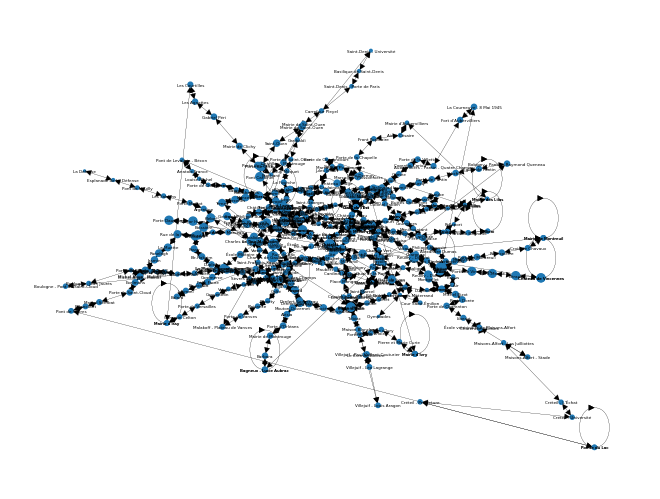

In [168]:

totat_traffic = sum(nx.get_node_attributes(test_network.network_graph, 'traffic').values())
node_size = [5000*node['traffic']/totat_traffic for node in test_network.network_graph.nodes.values()]
nx.draw(test_network.network_graph, node_size=node_size, width=0.1, pos=pos, labels=nx.get_node_attributes(test_network.network_graph, 'title'), font_size=3)

In [169]:
totat_traffic

7710100.0

In [170]:
sum(nx.get_node_attributes(new_net, 'traffic').values())

7715163.0

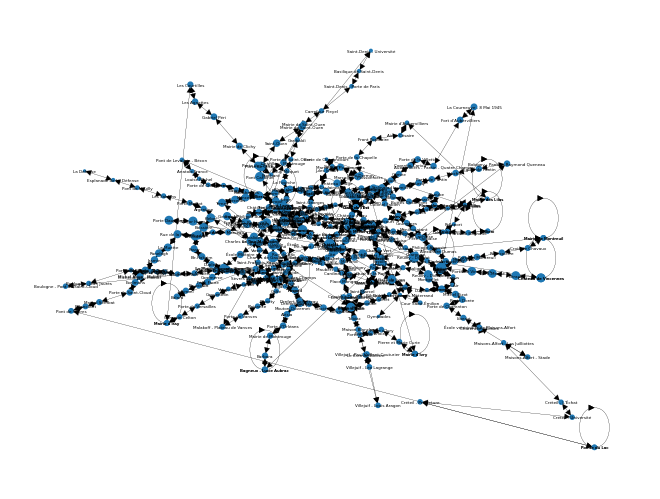

In [155]:

totat_traffic = sum(nx.get_node_attributes(test_network.network_graph, 'traffic').values())
node_size = [5000*node['traffic']/totat_traffic for node in new_net.nodes.values()]
nx.draw(new_net, node_size=node_size, width=0.1, pos=pos, labels=nx.get_node_attributes(new_net, 'title'), font_size=3)

In [159]:
test_network.network_graph.nodes[0]

{'title': 'Abbesses',
 'group': '12',
 'lon': 2.3379497756920697,
 'lat': 48.884594208027806,
 'traffic': 9622,
 'size': 10}

In [171]:
net_viz = Network(directed=True)
net_viz.from_nx(test_network.network_graph)
net_viz.save_graph('viz/network_graph_test.html')

In [172]:
net_viz = Network(directed=True)
net_viz.from_nx(new_net)
net_viz.save_graph('viz/network_graph_degraded.html')

In [31]:
len(test_network.network_graph.edges)

1054